In [1]:
import time
import copy
import random
import numpy as np
import distance
import math
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import optim

from IPython.display import Audio, display
def allDone():
    urL = 'http://www.wavsource.com/snds_2020-03-30_7102365145747638/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))
# allDone()

random.seed(666)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
motifs = np.genfromtxt('data__for_nerds/motifs.csv',dtype='U')
motifxFamMatrix = np.genfromtxt('data__for_nerds/motifxFamMatrix.csv',delimiter=',',dtype=int)
fams = np.genfromtxt('data__for_nerds/fams.csv',dtype='U')

print(len(motifs))

7866


In [3]:
def get_trigram_seq(motif):
    trigram_seq = []
    for i in range(len(motif)):
        trigram = motif[i:i+1]
        trigram_seq.append(trigram)
    return trigram_seq

all_grams = []
trigrammed_motifs = []
for motif in motifs:
    trigrammed_motif = get_trigram_seq(motif)
    trigrammed_motifs.append(trigrammed_motif)
    all_grams.extend(trigrammed_motif)
    
print(len(set(all_grams)))

22


In [4]:
def get_encoded_motifs(trigrammed_motifs, all_grams):
    gram_counts = Counter(all_grams)
    gram_list = sorted(gram_counts, key=gram_counts.get, reverse=True)
    gram_to_int = {gram:idx+1 for idx, gram in enumerate(gram_list)}  
    encoded_motifs = [[gram_to_int[gram] for gram in motif] for motif in trigrammed_motifs]
    return encoded_motifs, gram_to_int, gram_list

In [5]:
encoded_motifs, gram_to_int, gram_list = get_encoded_motifs(trigrammed_motifs, all_grams)

In [6]:
X_train, X_test = train_test_split(range(len(motifs)), test_size=0.15, random_state=666)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=666)

print(len(X_train), len(X_val), len(X_test))

5348 1338 1180


In [7]:
def get_random_motif_and_fam(idc):
    mIdx = random.choice(idc)  
    motif = encoded_motifs[mIdx] 
    fIdx = np.where(motifxFamMatrix[mIdx]==1)
    theseFams = fams[fIdx]
    return (mIdx,motif,fIdx,theseFams)

def get_batch(idc,batch_size):
    
    batch = []
    switch = 0
    
    while switch < batch_size:
        mIdx_1, motif_1, fIdx_1, fams_1 = get_random_motif_and_fam(idc)
        mIdx_2, motif_2, fIdx_2, fams_2 = get_random_motif_and_fam(idc)
        
        if len(fams_1)==0 and len(fams_2)==0: 
            continue
        
        label = distance.jaccard(set(fams_1),set(fams_2))
        if switch%2 != math.ceil(label):
            continue
        switch += 1
            
        triplet = [motif_1, motif_2, label]
        batch.append(triplet)

    return batch

In [8]:
from scipy.spatial import distance
class SiameseLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, z1, z2, label, margin=2.0):
#         euclidean_distance = F.pairwise_distance(z1, z2)
        manhattan_distance = torch.sum( torch.abs(z1-z2), axis=1)
        siam_loss = torch.mean((1-label) * torch.pow(manhattan_distance, 2) +
                                (label) * torch.pow(torch.clamp(margin - manhattan_distance, 
                                                                min=0.0), 2))
        return siam_loss

In [21]:
# from siameseNet_CNN import Model

import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    
### Conv1d(in_channels, out_channels, kernel_size, stride)
        
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=len(set(all_grams))+1, embedding_dim=64)        
        self.conv1 = nn.Conv1d(15, 16, 5)
        self.conv2 = nn.Conv1d(16, 32, 5)
        self.conv3 = nn.Conv1d(32, 64, 5)
        
        self.relu = nn.ReLU()
        self.drpt = nn.Dropout(p=0.5)
        self.pool = nn.MaxPool1d(2)
        
        self.penult = nn.Linear(256, 128)
        self.out = nn.Linear(128, 330)
        
    def forward_once(self, motif): 
#         print(motif.shape)
        
        embedded = self.embedding(motif)
#         print(embedded.shape)
        
        conv1 = self.conv1(embedded)
#         print(conv1.shape)
        conv1 = self.relu(conv1)
        conv1 = self.pool(conv1)
#         print("Pool:",conv1.shape)
        
        conv2 = self.conv2(conv1)
#         print(conv2.shape)
        conv2 = self.relu(conv2)
        conv2 = self.pool(conv2)
#         print("Pool:",conv2.shape)

        conv3 = self.conv3(conv2)
#         print(conv3.shape)
        conv3 = self.relu(conv3)
        conv3 = self.pool(conv3)
#         print("Pool:",conv3.shape)

        penult = conv3.view(conv3.size()[0], -1)
#         print(penult.shape)

        penult = self.penult(penult)
#         penult = self.relu(penult)
#         penult = self.drpt(penult)


        out = self.out(penult)
#         out = self.drpt(out)

#         print(out.shape)

        return out
        
    def forward(self, motifs_net1, motifs_net2):
        embed_1 = self.forward_once(motifs_net1)
        embed_2 = self.forward_once(motifs_net2)
        return (embed_1, embed_2)

In [22]:
def train(model, idc, optimizer, criterion, iters, batch_size):
    
    model.train()
    loss_history = 0
    
    for i in range(iters):
            
        batch = get_batch(idc, batch_size)
        motifs_net1 = torch.stack([torch.tensor(x[0]).to(device) for x in batch])
        motifs_net2 = torch.stack([torch.tensor(x[1]).to(device) for x in batch])
        labels = torch.stack([torch.tensor(x[2]).to(device) for x in batch])
        
        optimizer.zero_grad()
        
        embeds_1, embeds_2 = model(motifs_net1, motifs_net2)
        loss = criterion(embeds_1, embeds_2, labels)
        
        loss.backward()
        optimizer.step()
                
        loss_history += loss.item()
        
    return loss_history / iters

In [23]:
def evaluate(model, idc, criterion, iters, batch_size):
    
    model.eval()
    loss_history = 0

    with torch.no_grad():
        
        for i in range(iters):
            batch = get_batch(idc, batch_size)
            motifs_net1 = torch.stack([torch.tensor(x[0]).to(device) for x in batch])
            motifs_net2 = torch.stack([torch.tensor(x[1]).to(device) for x in batch])
            labels = torch.stack([torch.tensor(x[2]).to(device) for x in batch])
            
            embeds_1, embeds_2 = model(motifs_net1, motifs_net2)
            loss = criterion(embeds_1, embeds_2, labels)
                
            loss_history += loss.item()
            
    return loss_history / iters

In [24]:
model = Model() 
model = model.to(device)
# print(model)
optimizer = optim.Adam(model.parameters(), lr = 0.005 ) 
criterion = SiameseLoss()

batch_size = 64
sub_iters = 100

super_iters = 100

In [25]:
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
total_time = time.time()

for i in range(super_iters):
    start = time.time()
    train_loss = train(model, X_train, optimizer, criterion, iters=sub_iters, batch_size=batch_size)
    val_loss = evaluate(model, X_val, criterion, iters=sub_iters, batch_size=batch_size)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print("Time: %5.3f secs, Super iter %d\n* Train loss %5.4f | Val loss: %5.4f" % 
          ( time.time()-start, i+1, train_loss, val_loss ))

final_model = Model().to(device)
final_model.load_state_dict(best_model_wts)

print("Total train time: %5.3f mins" % ( (time.time()-total_time)/60 ))
allDone()

Time: 5.578 secs, Super iter 1
* Train loss 1.1387 | Val loss: 0.8317
Time: 4.784 secs, Super iter 2
* Train loss 0.7456 | Val loss: 0.7729
Time: 4.788 secs, Super iter 3
* Train loss 0.7271 | Val loss: 0.9123
Time: 5.428 secs, Super iter 4
* Train loss 0.6893 | Val loss: 0.7432
Time: 5.336 secs, Super iter 5
* Train loss 0.6476 | Val loss: 0.6752
Time: 5.070 secs, Super iter 6
* Train loss 0.6774 | Val loss: 0.6697
Time: 5.018 secs, Super iter 7
* Train loss 0.6551 | Val loss: 0.6950
Time: 5.029 secs, Super iter 8
* Train loss 0.6490 | Val loss: 0.7730
Time: 4.952 secs, Super iter 9
* Train loss 0.6296 | Val loss: 0.6444
Time: 4.637 secs, Super iter 10
* Train loss 0.5961 | Val loss: 0.6465
Time: 4.689 secs, Super iter 11
* Train loss 0.6119 | Val loss: 0.6965
Time: 4.814 secs, Super iter 12
* Train loss 0.5970 | Val loss: 0.6874
Time: 5.018 secs, Super iter 13
* Train loss 0.6445 | Val loss: 0.7376
Time: 4.866 secs, Super iter 14
* Train loss 0.6189 | Val loss: 0.7196
Time: 5.171 sec

In [26]:
run = '06'
torch.save(model.state_dict(), "siameseWeights_%s" % run)

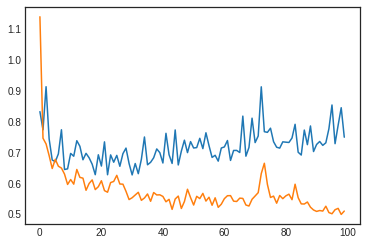

In [27]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(val_loss_history)
plt.plot(train_loss_history)
plt.savefig("FIGS_siam/" + run + "_loss")
plt.show()

In [28]:
def get_embedding(model,idc):
    model.eval()
    to_embed = torch.tensor(np.array((encoded_motifs))).to(device)
    motifs = to_embed [idc]
    embedding = model.forward_once(motifs)
    return embedding.cpu().detach().numpy()

test = get_embedding(model, range(len(motifs)))   #range(len(motifs)))

In [29]:
df = pd.DataFrame(test,dtype=float)
df.to_csv("emb_%s_embedding.csv" % (run),header=None,index=None)

In [30]:
import umap.umap_ as umap
umapper = umap.UMAP(
    n_neighbors=200, # 200 for 90 dims
    min_dist=1.0, # 1.0 for 90 dims
    n_components=2,
    metric='euclidean' )

s = time.time()
pos_umap = umapper.fit_transform(test)
# allDone()

print ("secs: %5.3f" % (time.time()-s))

/usr/local/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../usr/local/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/usr/local/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


secs: 122.901


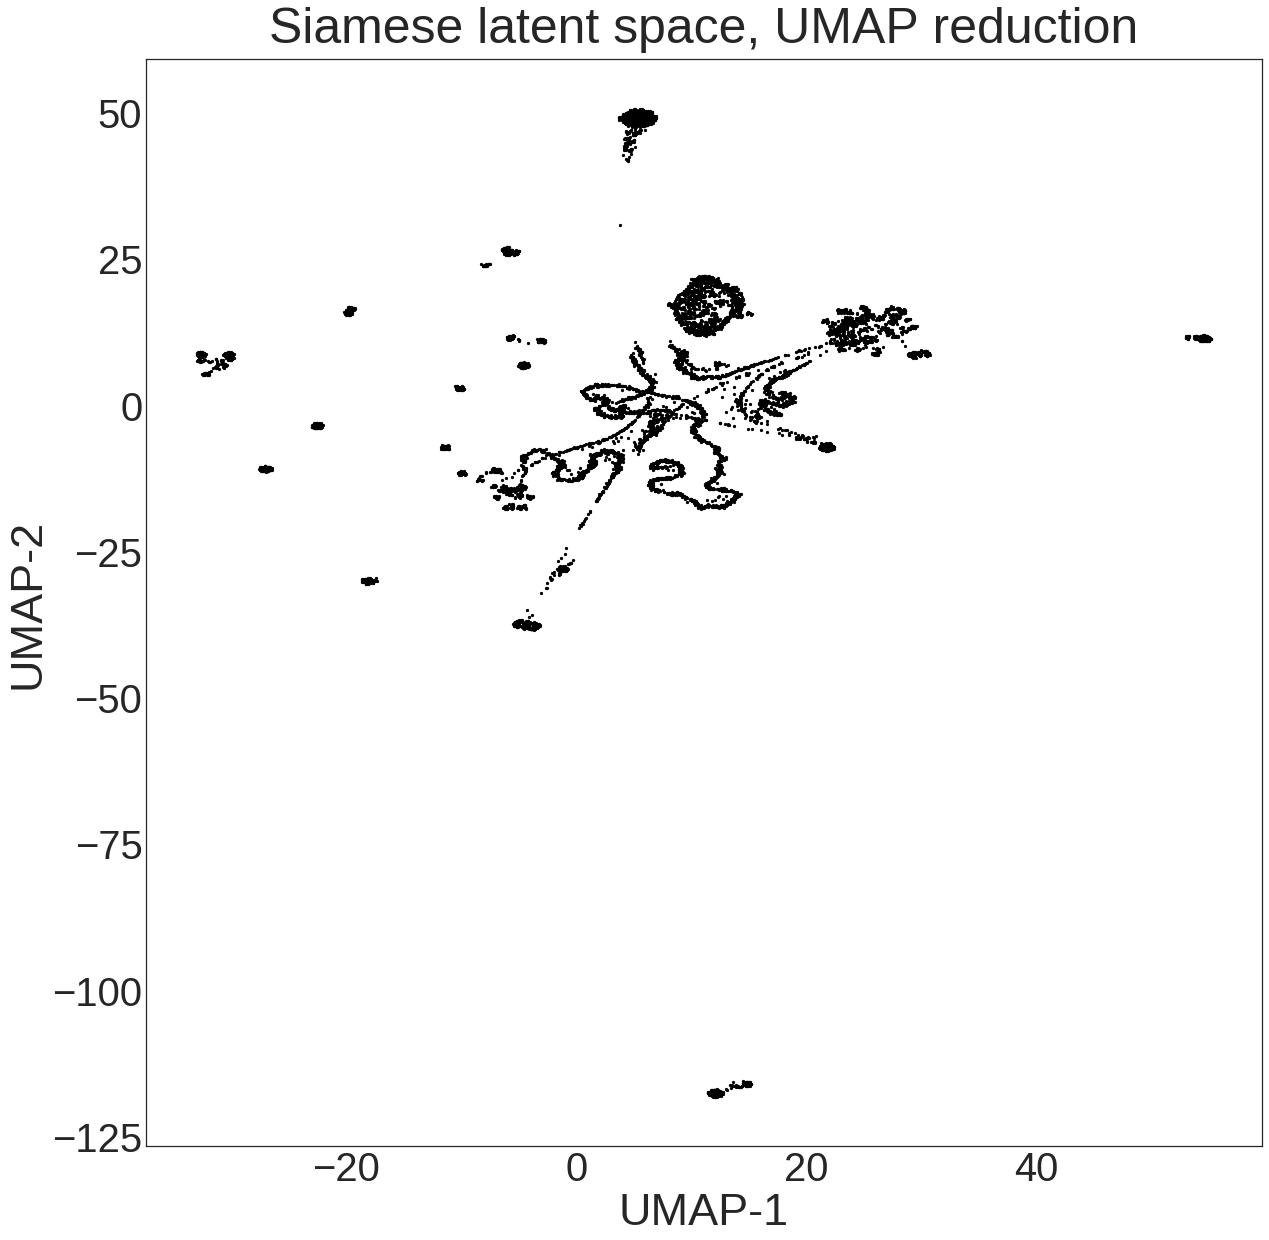

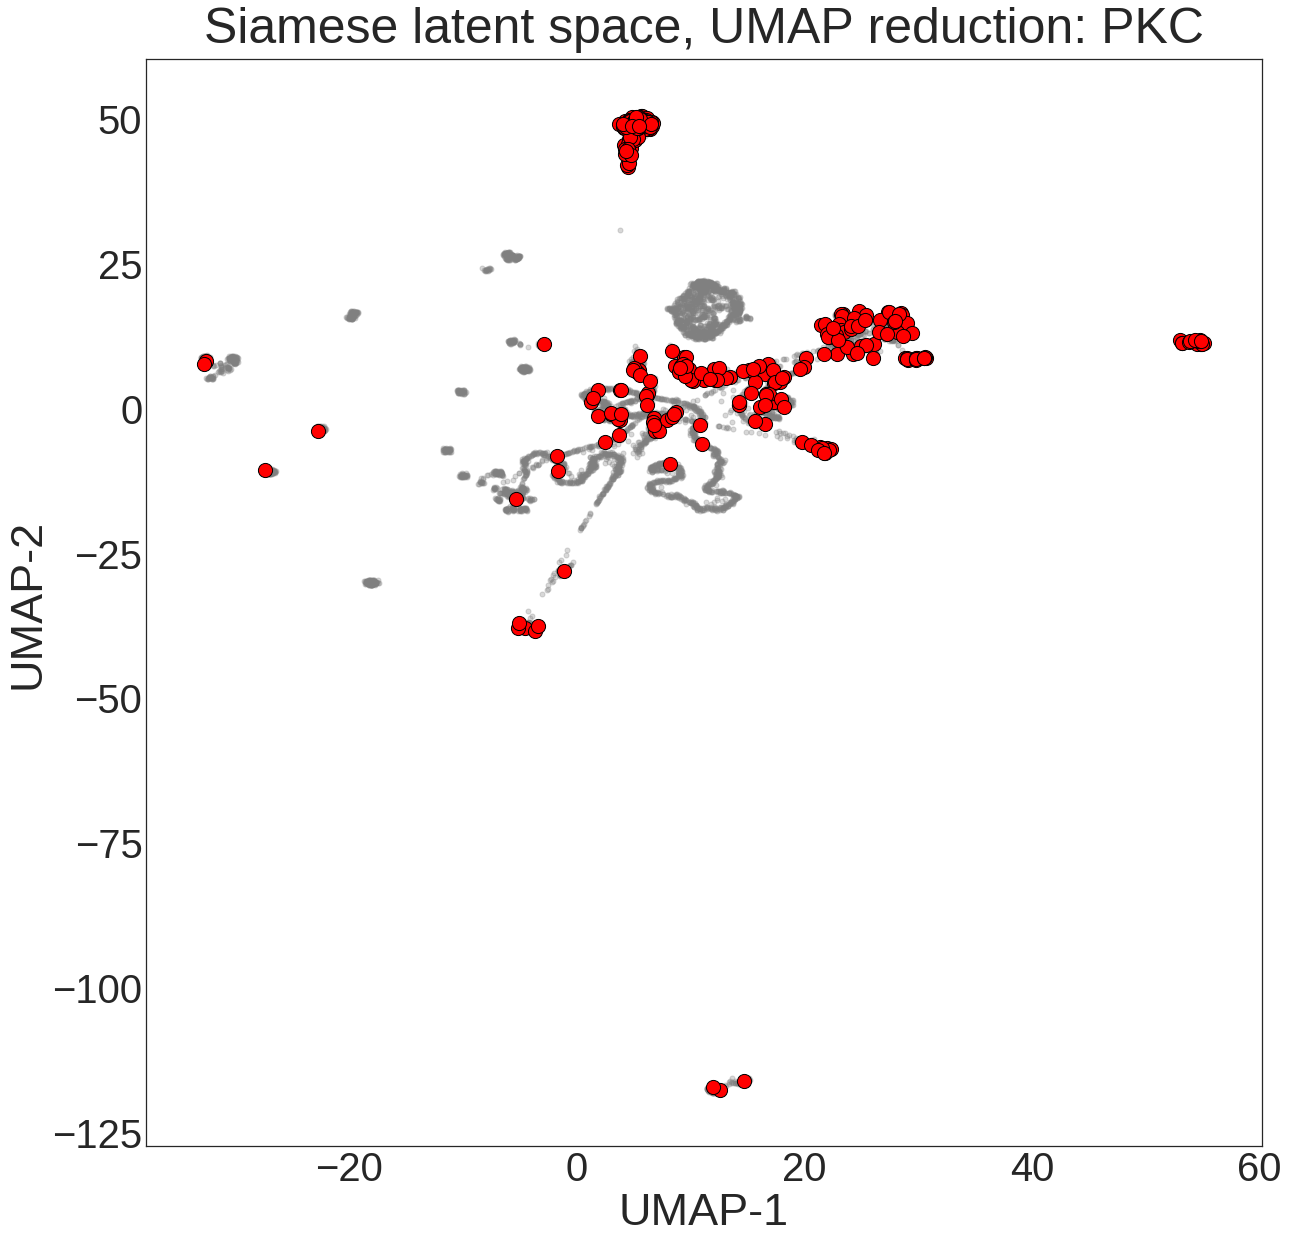

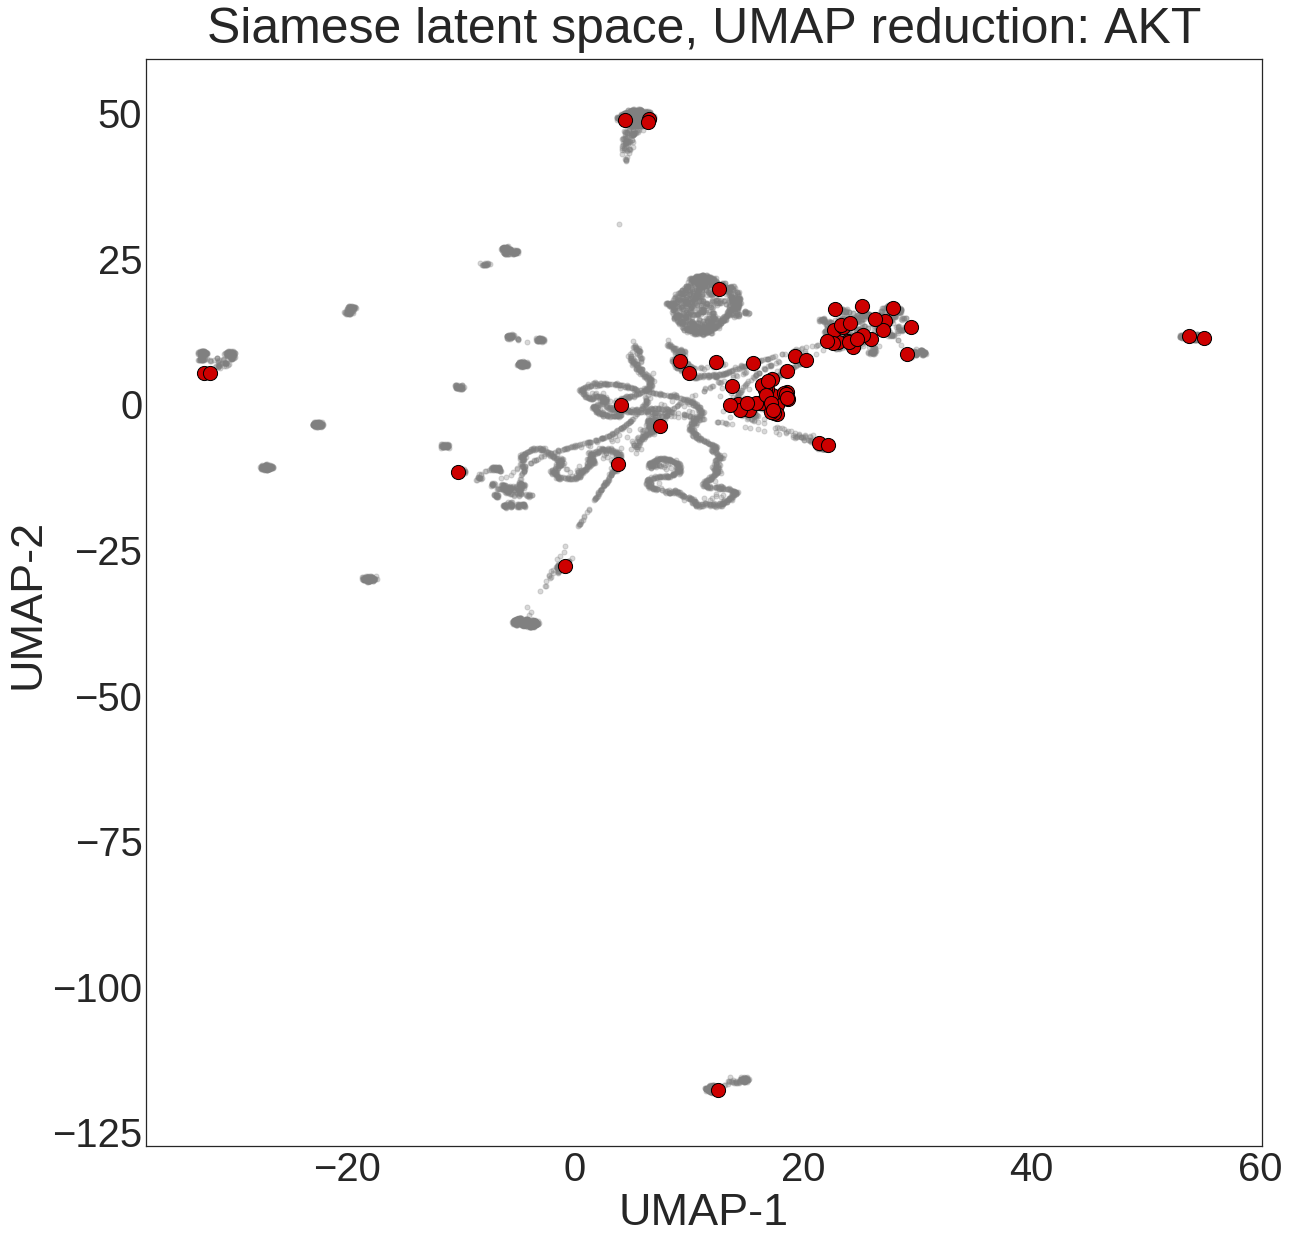

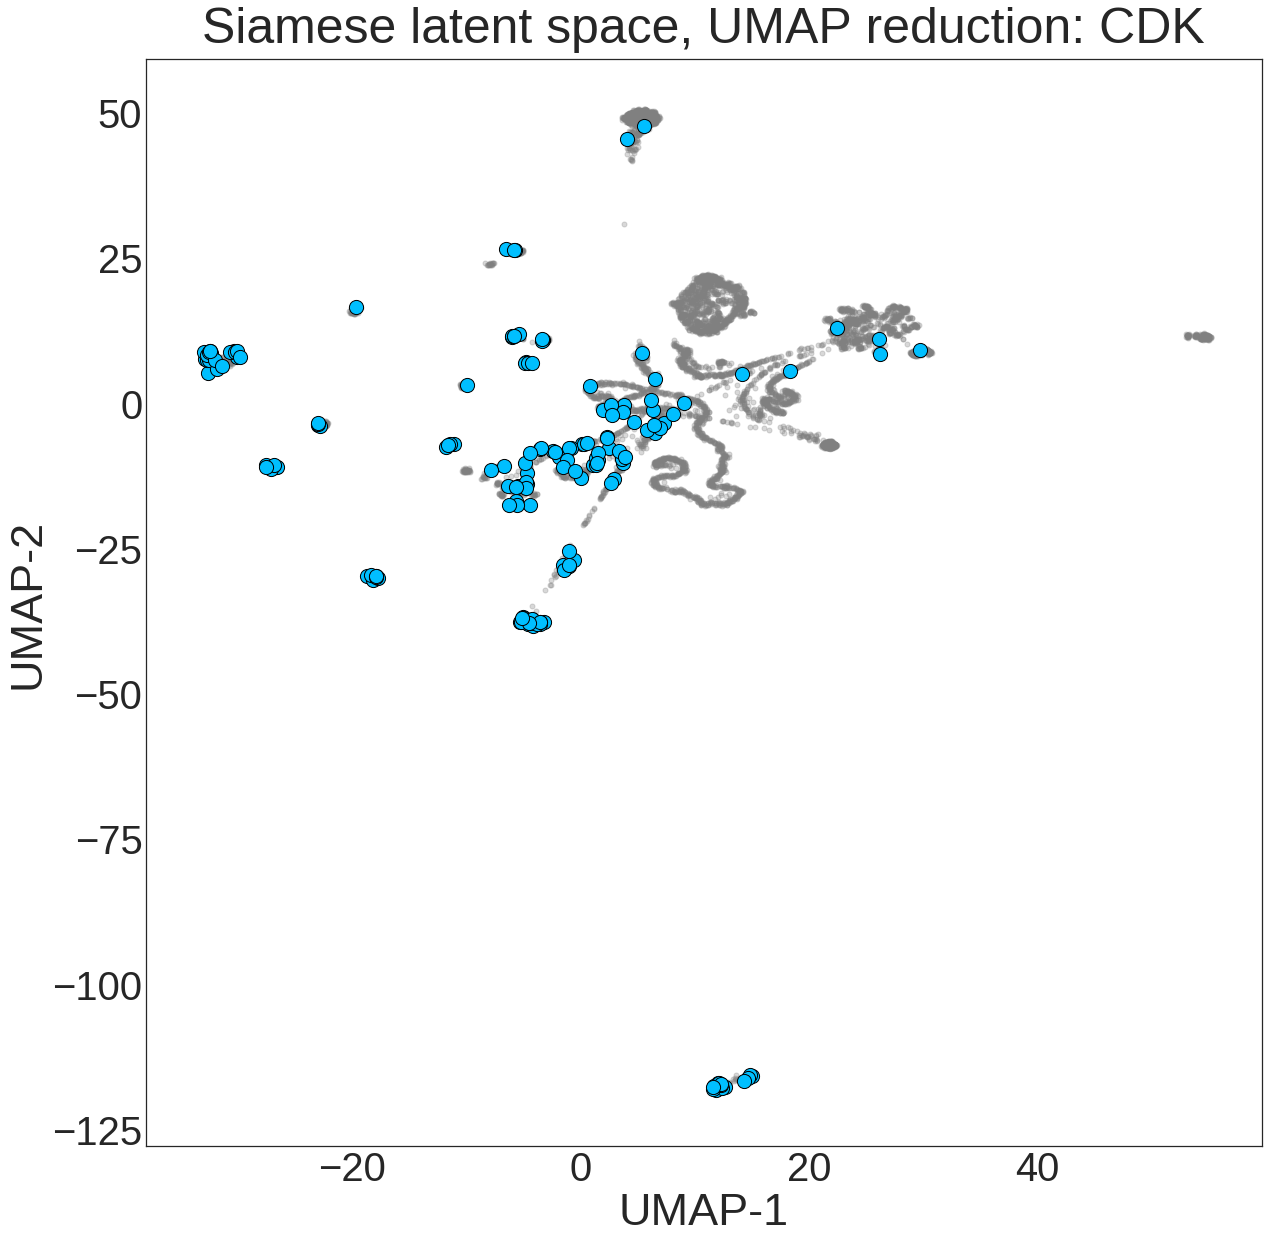

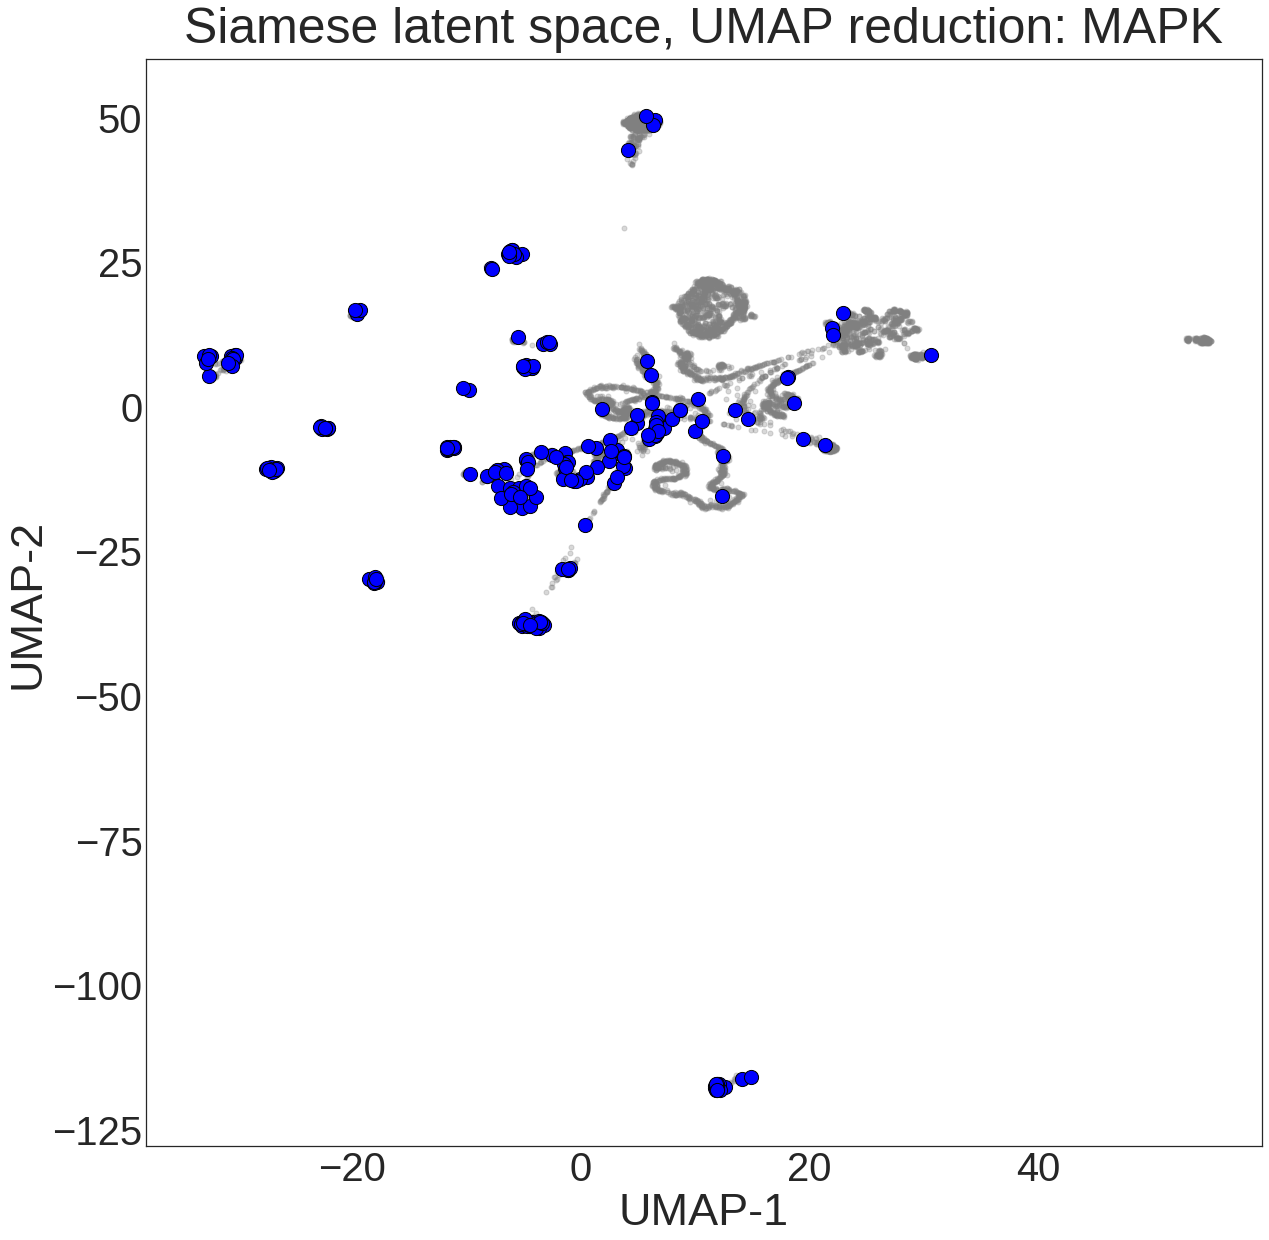

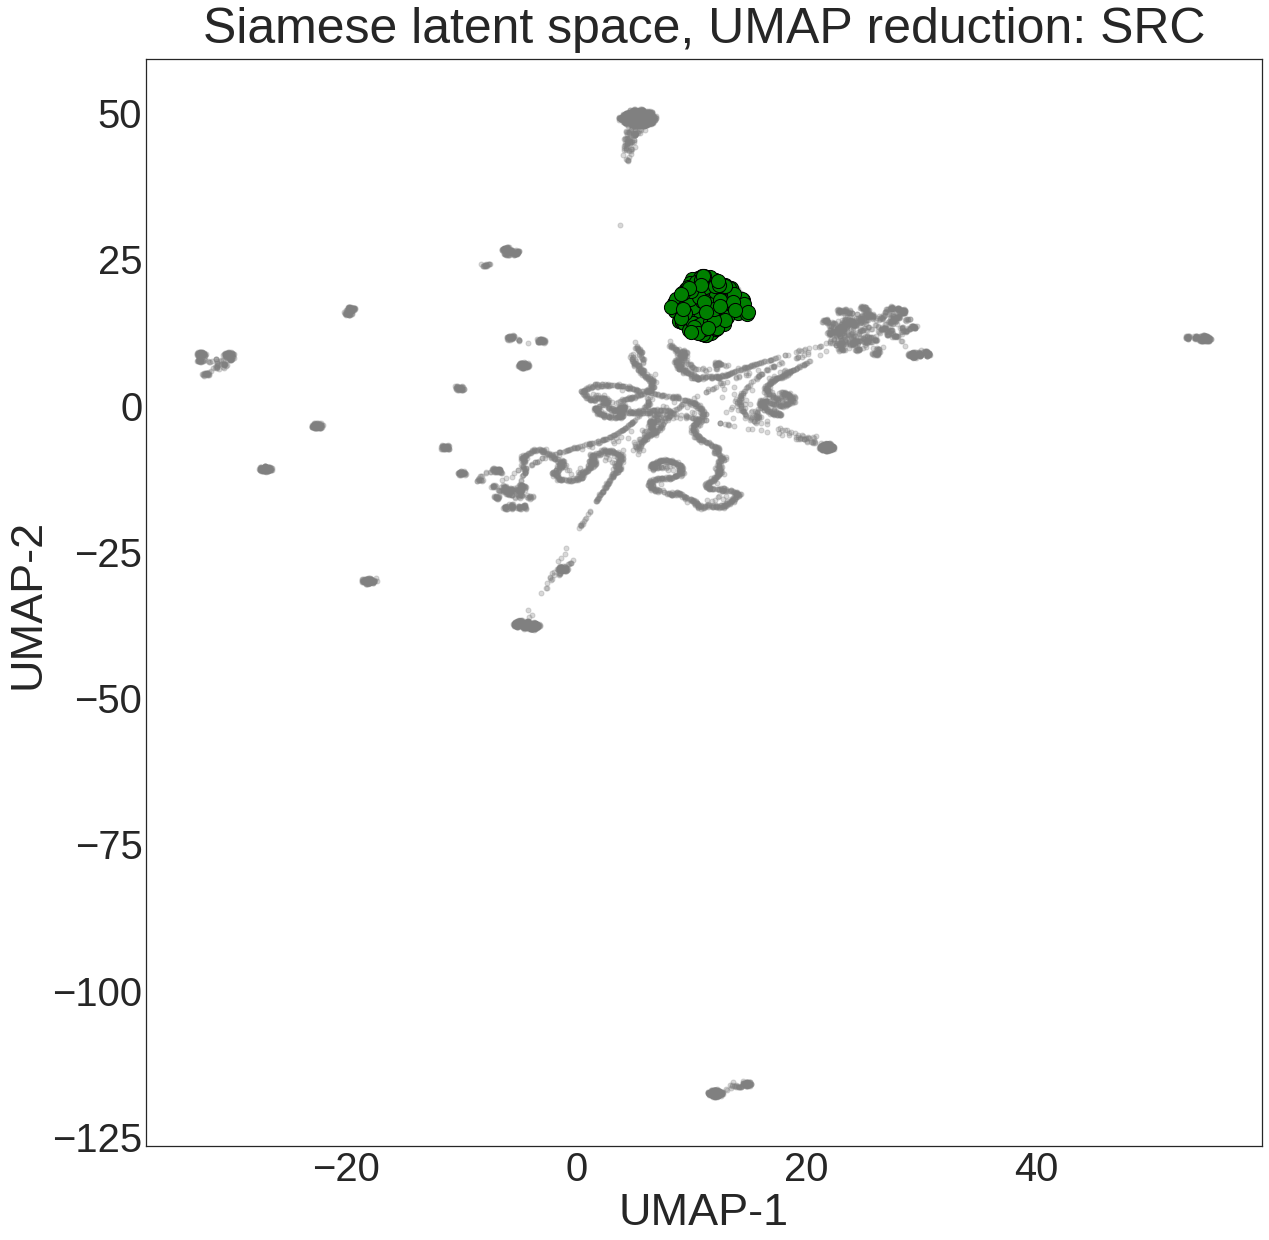

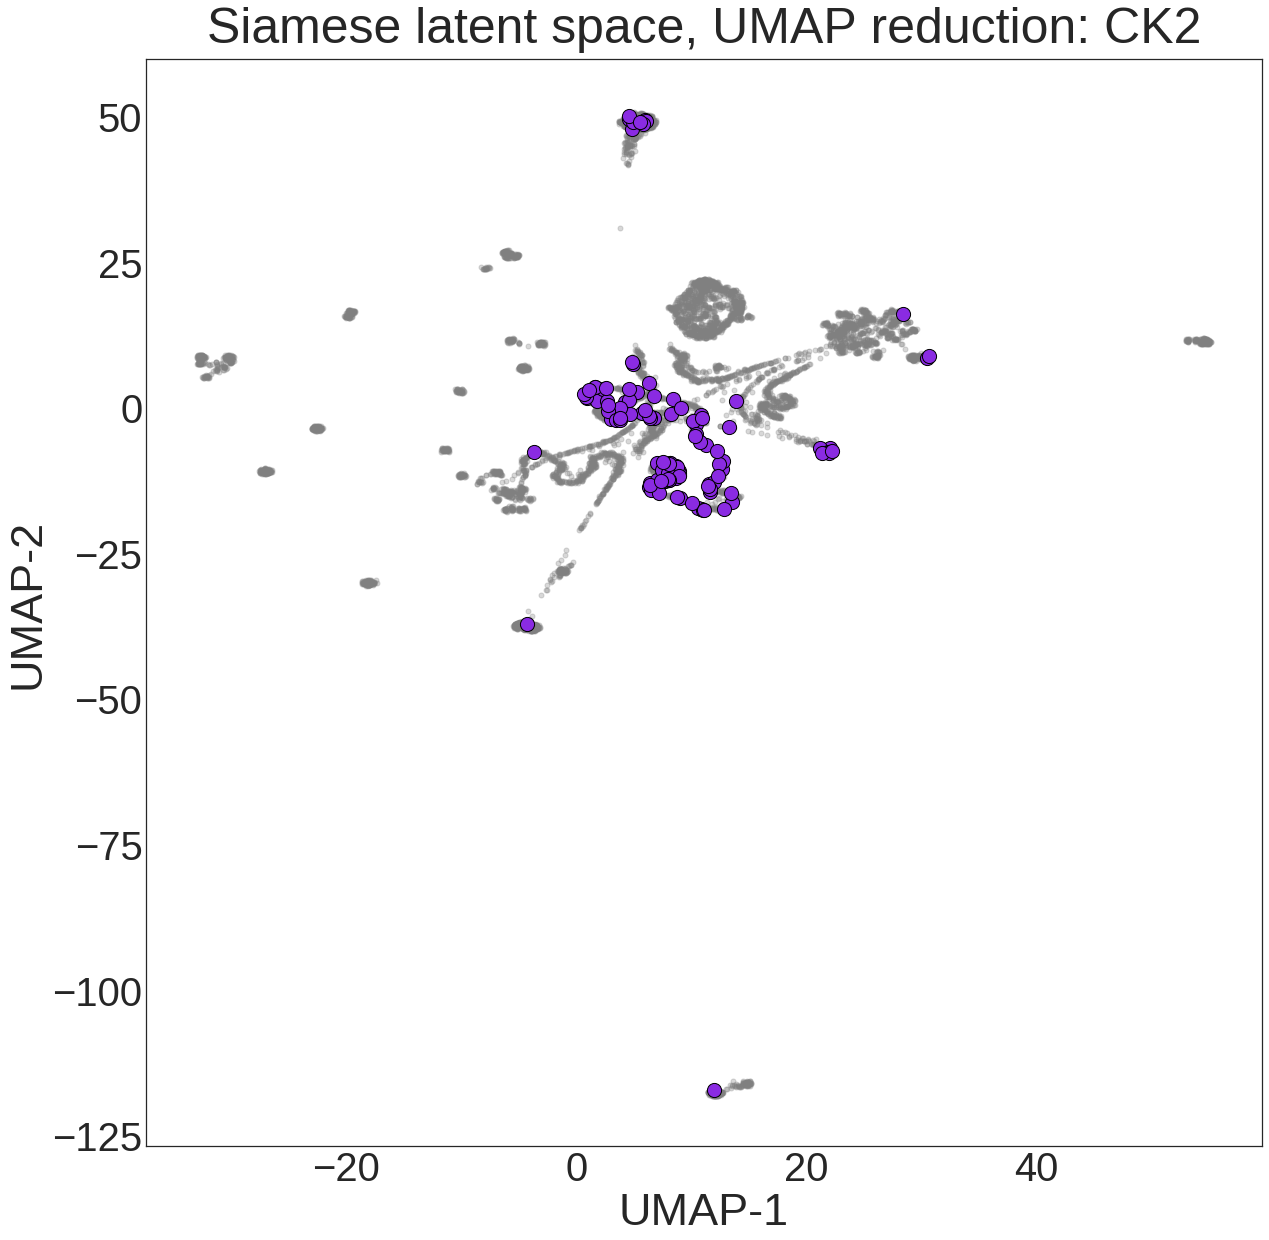

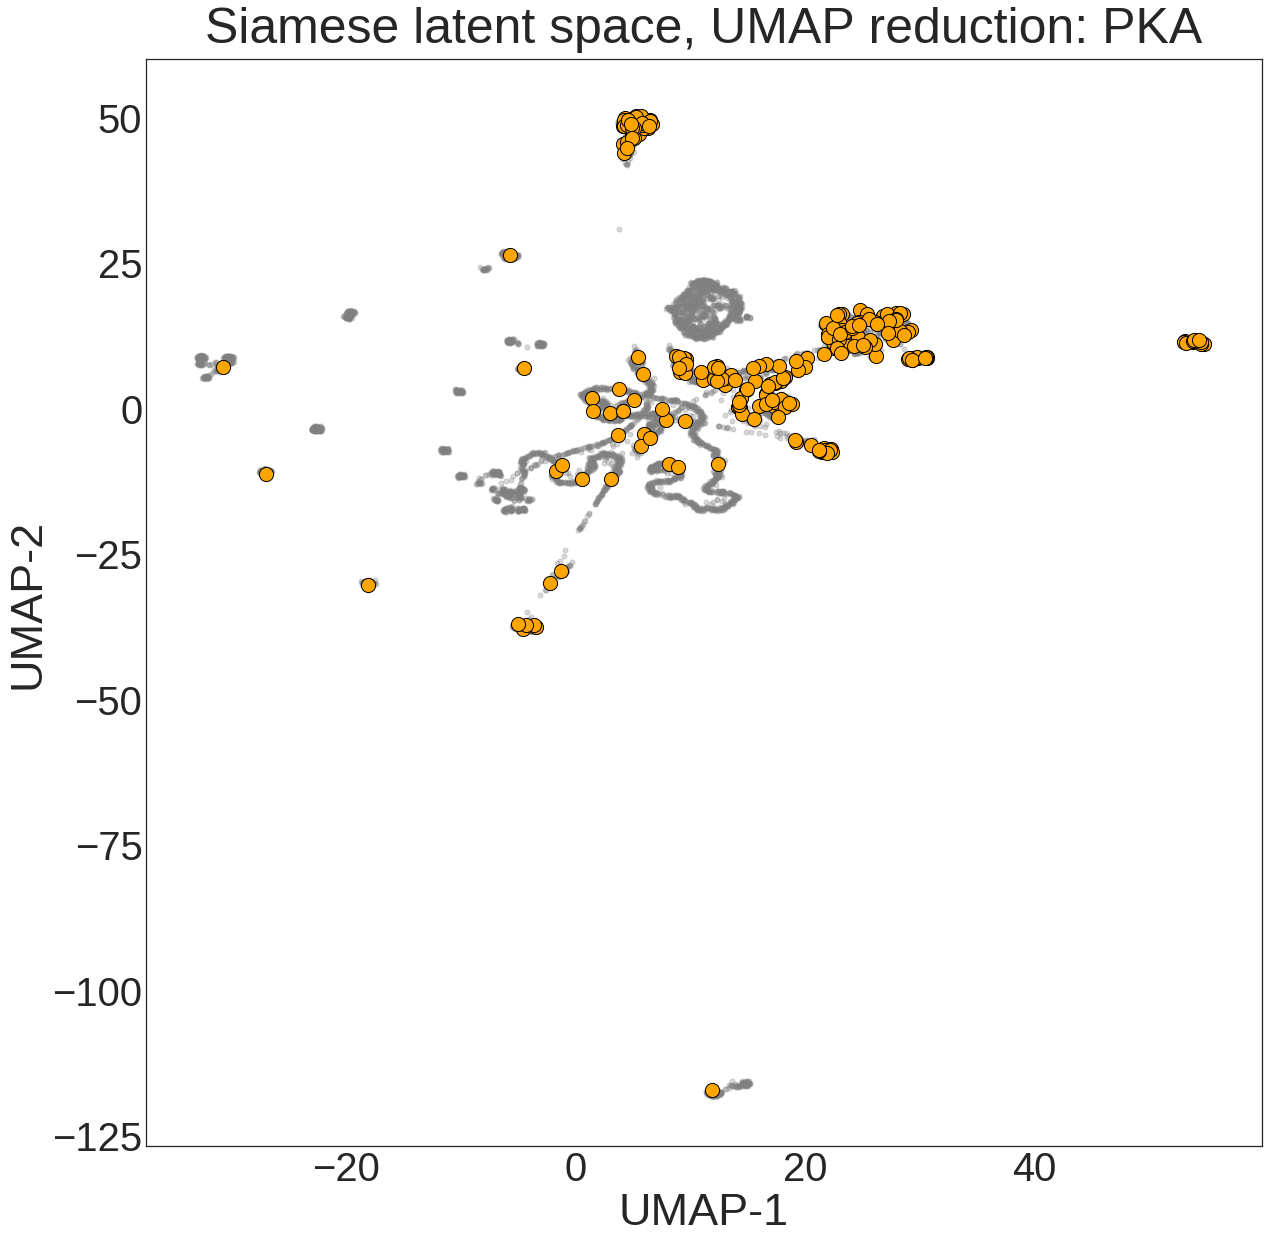

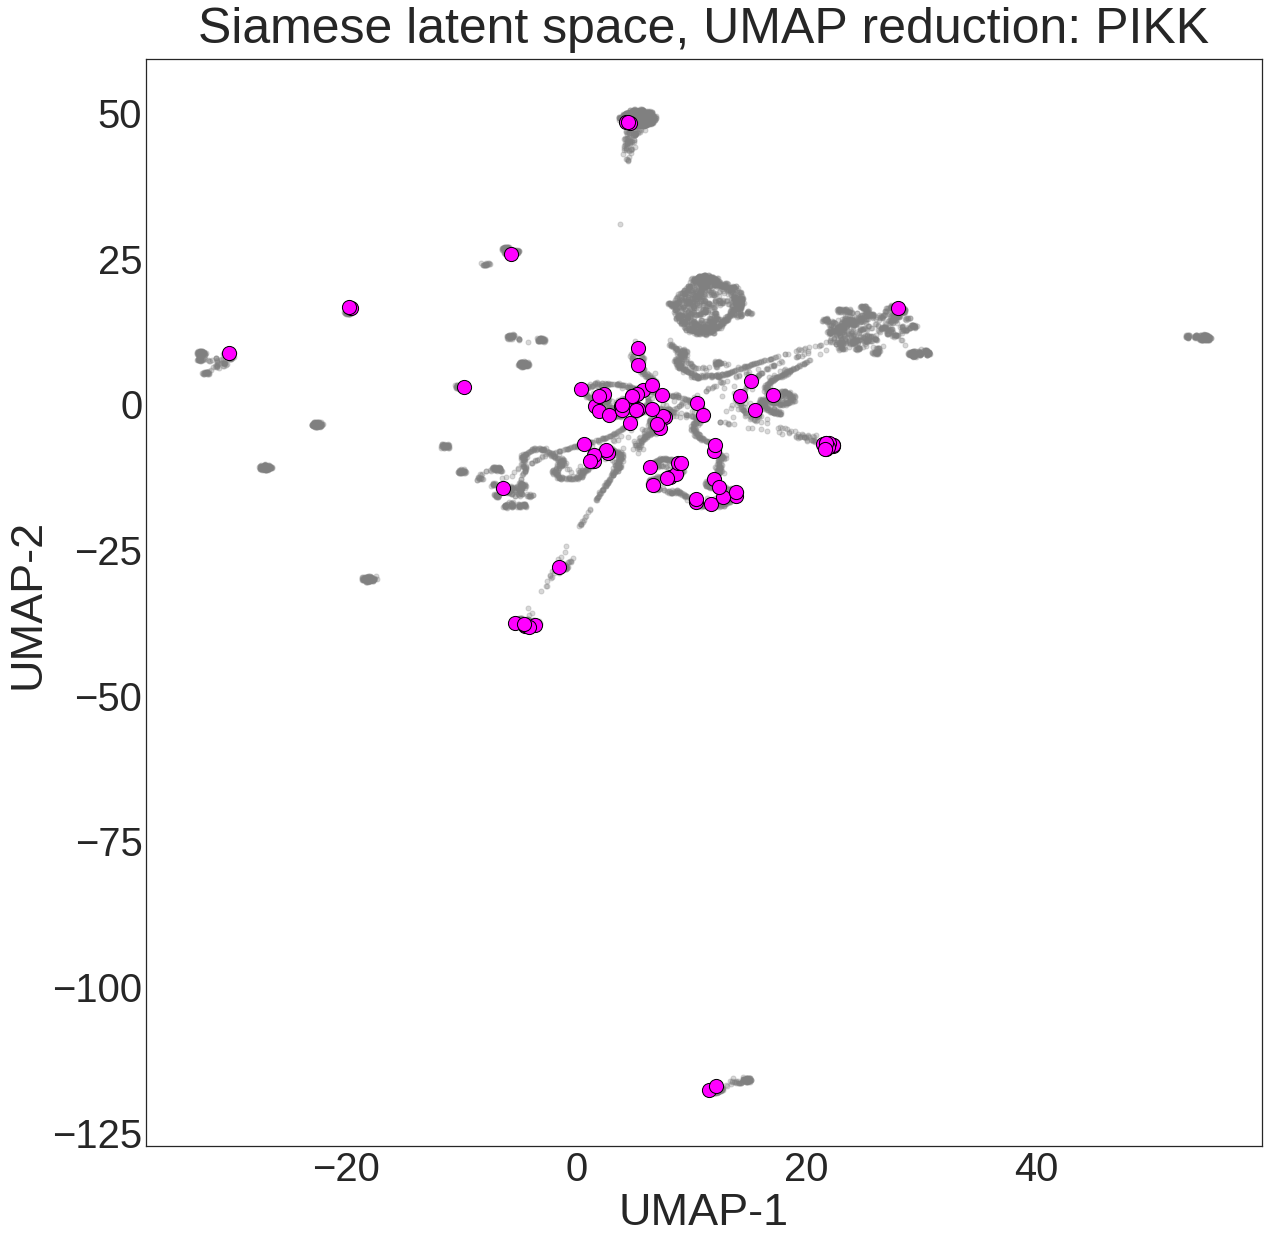

In [31]:
import os
f = 'FIGS_siam/' + run + "/"
os.mkdir(f)

label_size = 45
title_size = 50
tick_size = 40

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

colors = ['red','#CD0000','deepskyblue','blue','green','blueviolet','orange','magenta','blueviolet','violet','deeppink','crimson','mediumslateblue','brown']

plt.figure(figsize=(20,20))
plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black', alpha=1) #alpha=0.25)
plt.title("Siamese latent space, UMAP reduction",fontsize=title_size,y=1.01)
plt.xlabel("UMAP-1",fontsize=label_size)
plt.ylabel("UMAP-2",fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig( f + "noHighlights")
plt.show()

pop_fams = ['PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK']
# pop_fams = ['CAMK-UNIQUE', 'DYRK', 'CAMKL', 'STE20', 'PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK']


i = -1
for _,fam in enumerate(pop_fams):
    
    i+=1
    fIdx = np.where(fams==fam)[0][0]
    plt.figure(figsize=(20,20))
    plt.title(("Siamese latent space, UMAP reduction: %s" % fam),fontsize=title_size,y=1.01)
    plt.xticks(fontsize=tick_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    plt.yticks(fontsize=tick_size)
    plt.xlabel("UMAP-1",fontsize=label_size)
    plt.ylabel("UMAP-2",fontsize=label_size)
    plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=25,color='grey',alpha=0.30)
    for mIdx, (x, y) in enumerate(zip(pos_umap[:, 0], pos_umap[:, 1])):
        if mIdx not in X_test:
            continue
        elif motifxFamMatrix[mIdx][fIdx]==1:
            plt.scatter(x,y,marker='o',s=200,c=colors[i],alpha=1.0,edgecolors='black')          
    plt.savefig((f+"%s" % fam))
    plt.show()

In [20]:
allDone()